In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


In [15]:
# Load the datasets
train_df = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test_df = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

In [16]:
# Display basic information about the datasets
train_info = train_df.info()
test_info = test_df.info()

train_head = train_df.head()
test_head = test_df.head()

train_info, train_head, test_info, test_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

(None,
   last contact date  age           job  marital  education default  balance  \
 0        2009-04-17   26   blue-collar  married  secondary      no      647   
 1        2009-10-11   52    technician  married  secondary      no      553   
 2        2010-11-20   44   blue-collar  married  secondary      no     1397   
 3        2009-09-01   33        admin.  married  secondary      no      394   
 4        2008-01-29   31  entrepreneur   single   tertiary      no      137   
 
   housing loan    contact  duration  campaign  pdays  previous poutcome target  
 0     yes   no   cellular       357         2    331         1    other     no  
 1     yes   no  telephone       160         1     -1         0      NaN     no  
 2      no   no   cellular       326         1     -1         0      NaN     no  
 3     yes   no  telephone       104         3     -1         0      NaN     no  
 4      no   no   cellular       445         2     -1         0      NaN     no  ,
 None,
   last con

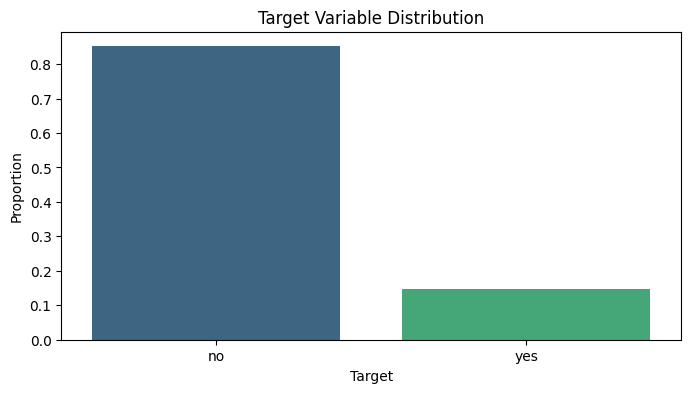

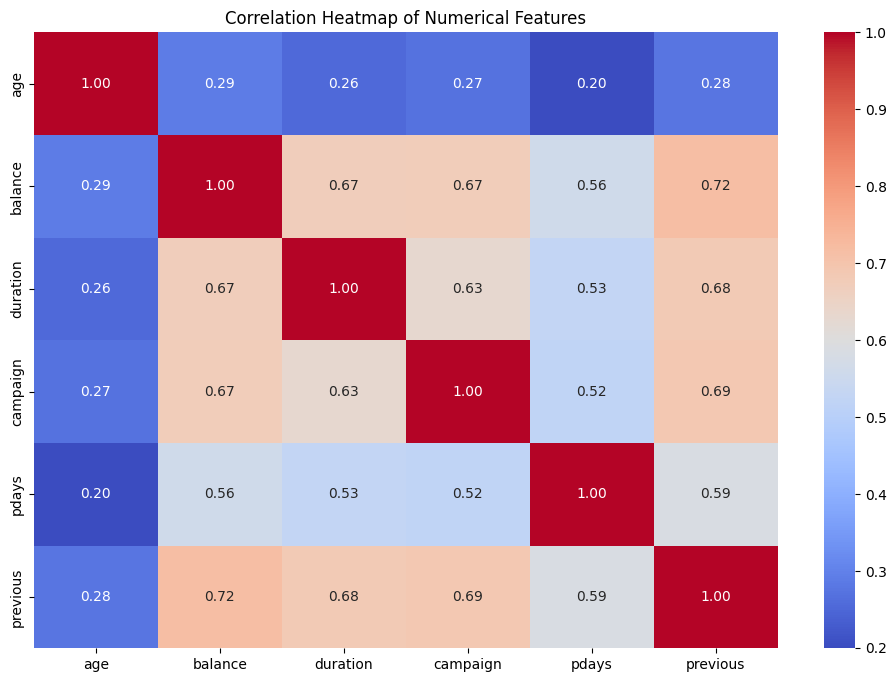

(age                  0
 job                229
 marital              0
 education         1467
 default              0
 balance              0
 housing              0
 loan                 0
 contact          10336
 duration             0
 campaign             0
 pdays                0
 previous             0
 poutcome         29451
 target               0
 contact_day          0
 contact_month        0
 contact_year         0
 dtype: int64,
 age                 0
 job                59
 marital             0
 education         390
 default             0
 balance             0
 housing             0
 loan                0
 contact          2684
 duration            0
 campaign            0
 pdays               0
 previous            0
 poutcome         7508
 contact_day         0
 contact_month       0
 contact_year        0
 dtype: int64,
                 age        balance      duration      campaign         pdays  \
 count  39211.000000   39211.000000  39211.000000  39211.000000  3

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert `last contact date` to datetime format in both datasets
train_df['last contact date'] = pd.to_datetime(train_df['last contact date'], errors='coerce')
test_df['last contact date'] = pd.to_datetime(test_df['last contact date'], errors='coerce')

# Extracting day, month, and year from `last contact date`
for df in [train_df, test_df]:
    df['contact_day'] = df['last contact date'].dt.day
    df['contact_month'] = df['last contact date'].dt.month
    df['contact_year'] = df['last contact date'].dt.year

# Drop original `last contact date` column as it's no longer needed
train_df.drop(columns=['last contact date'], inplace=True)
test_df.drop(columns=['last contact date'], inplace=True)

# Summarizing missing values
missing_values_train = train_df.isnull().sum()
missing_values_test = test_df.isnull().sum()

# Numerical and categorical columns
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# Removing the target column from categorical columns for EDA purposes
categorical_cols.remove('target')

# Statistical summary of numerical columns
numerical_summary = train_df[numerical_cols].describe()

# Distribution of the target variable
target_distribution = train_df['target'].value_counts(normalize=True)

# Visualization of target variable distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=target_distribution.index, y=target_distribution.values, palette="viridis")
plt.title('Target Variable Distribution')
plt.ylabel('Proportion')
plt.xlabel('Target')
plt.show()

# Visualize correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
correlation_matrix = train_df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

missing_values_train, missing_values_test, numerical_summary

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Handling missing values
for col in ['job', 'education', 'contact']:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

# Dropping `poutcome` due to high percentage of missing values
train_df.drop(columns=['poutcome'], inplace=True)
test_df.drop(columns=['poutcome'], inplace=True)

# Capping outliers in `balance` and `campaign`
for col, cap in [('balance', 30000), ('campaign', 20)]:
    train_df[col] = np.clip(train_df[col], -cap, cap)
    test_df[col] = np.clip(test_df[col], -cap, cap)

# Encoding categorical variables
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('target')  # Exclude target from encoding

train_encoded = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

# Align test data with training data (to handle potential column mismatches)
test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)

# Scaling numerical features
scaler = MinMaxScaler()
numerical_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
train_encoded[numerical_cols] = scaler.fit_transform(train_encoded[numerical_cols])
test_encoded[numerical_cols] = scaler.transform(test_encoded[numerical_cols])

# Final training and test datasets
X_train = train_encoded.drop(columns=['target'])
y_train = train_encoded['target'].map({'yes': 1, 'no': 0})
X_test = test_encoded.drop(columns=['target'], errors='ignore')

X_train.head(), y_train.head(), X_test.head()

# Feature Engineering
X_train['was_contacted_before'] = (X_train['pdays'] != -1).astype(int)
X_test['was_contacted_before'] = (X_test['pdays'] != -1).astype(int)

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [20]:
# Initialize models
svc = SVC(kernel='rbf', random_state=42, probability=True)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(random_state=42, max_iter=1000)

# Dictionary to store models and their results
models = {'SVC': svc, 'RFC': rfc, 'Logistic Regression': lr}
results = {}

In [21]:
# Train and evaluate models using 5-fold cross-validation
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[model_name] = {
        'Mean Accuracy': scores.mean(),
        'Accuracy Std Dev': scores.std()
    }
    print(f"{model_name} - Mean Accuracy: {scores.mean():.4f}, Std Dev: {scores.std():.4f}")

SVC - Mean Accuracy: 0.8514, Std Dev: 0.0001
RFC - Mean Accuracy: 0.8677, Std Dev: 0.0021
Logistic Regression - Mean Accuracy: 0.8520, Std Dev: 0.0016


In [22]:
# Fit each model on the training data
for model_name, model in models.items():
    model.fit(X_train, y_train)

In [23]:
# Predictions on the test set
test_predictions = {}
for model_name, model in models.items():
    test_predictions[model_name] = model.predict(X_test)

In [ ]:
# Save predictions for further analysis
test_predictions_df = pd.DataFrame(test_predictions)
test_predictions_df.index = test_df.index  # Align indices with original test data
test_predictions_df.to_csv('/kaggle/working/test_predictions.csv', index_label='Index')

In [24]:
# Choose the best model based on cross-validation accuracy
best_model_name = max(results, key=lambda x: results[x]['Mean Accuracy'])
best_model = models[best_model_name]

# Generate predictions using the best model
test_predictions_best = best_model.predict(X_test)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df.index,  # Ensure indices align with the test data
    'target': test_predictions_best
})

# Convert numeric predictions back to "yes" or "no"
submission_df['target'] = submission_df['target'].map({1: 'yes', 0: 'no'})

# Save the predictions in the submission format
submission_file_path = '/kaggle/working/submission.csv'
submission_df.to_csv(submission_file_path, index=False)
